# Efficient Frontier Constraint Optimisations

In [267]:
import data, calculations

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pypfopt import CLA, plotting
from pypfopt.expected_returns import returns_from_prices, log_returns_from_prices, mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import objective_functions

from IPython.core.interactiveshell import InteractiveShell


InteractiveShell.ast_node_interactivity = "all"
pd.options.display.max_columns = None

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Purpose of Constraints 

### Sector Constraints

Through the correlation matrix, we can observe the relationship one stock has with another. If this correlation is high for many 
stocks within the portfolio, then it's common for that portfolio to contain many stocks which are catagorised into same sector. 

Thus, to increase diversification within the portfolio, we optimise weights such that a portfolio does not rely too heavily on a specific sector, such as placing an upper limit on technology stocks or a minimum weighting on utilites. Through this, we ensure a more diversified portfolio where we can hopefully present greater returns.

The first step is to look at generalised portfolios over a given time frame. We don't select a particular portfolio for the reason of observing which porfolios operate the best through the sector constraints; if we chose a portfolio containing the top 10 stocks with highest expected returns, the porfolio might not be diversified enough to distinguish the effect with these sector constraints. Thus, by analysing portfolios with randomised stocks, we can more easily quantify which stocks garnered the best returns when constraints are added into the optmisation criteria.

### L2 Regularisation (Ridge Regression)

When using the efficient frontier optimiser, there are many instances for portfolios to contain stocks with a weight of zero, hence as if the stock was not in the portfolio to begin with. To combat this issue of negligible weights, we utilise a regression technique called similar to L2 regularisation, otherwise known as ridge regularisation, adding a penalty term when calculating the risk via the covariance matrix. The L2 penalty, which equals the square of the magnitude of coefficients for the weights of stocks, gets minimised. If the weights are all equally distributed throughout the portfolio, then this value will be at a minimum, and will obtain a maximum value in the case of the entire portfolio being allocated to one asset. 

<!-- \begin{split}\begin{equation*}
\begin{aligned}
& \underset{w}{\text{minimise}} & & w^T \Sigma w \\
& \text{subject to} & & w^T\mu \geq \mu^*\\
&&& w^T\mathbf{1} = 1 \\
&&& w_i \geq 0 \\
\end{aligned}
\end{equation*}\end{split} -->

Below is how the optimiser computes L2 regularisation. Originally, the optimiser simply 

\begin{split}\begin{equation*} \underset{w}{\text{minimise}} ~ \left\{w^T \Sigma w \right\} ~~~ \longrightarrow ~~~
\underset{w}{\text{minimise}} ~ \left\{w^T \Sigma w + \gamma w^T w \right\} \end{equation*}\end{split}

Thus, by adding this cost as a constraint, we push the optimisation model to choose different, non-zero weights for stocks which once were neglibile.

## Sector Constraints

We begin by importing a dataframe which contains all the sectors for the given time period. 

This data has been scraped using wikipedia and a public API, Financial Modelling Prep, and cleaned within another notebook.

In [2]:
smp500_sectors = pd.read_csv('../sectors.csv', index_col=0)
smp500_sectors
print("11 unique GICS Sector classications for stocks.")
list(smp500_sectors["GICS Sector"].unique())

,GICS Sector
Symbol,
A US Equity,Healthcare
AA US Equity,Materials
AAL US Equity,Industrials
AAP US Equity,Consumer Discretionary
AAPL US Equity,Information Technology
...,...
XYL US Equity,Industrials
YUM US Equity,Consumer Discretionary
ZBH US Equity,Healthcare


11 unique GICS Sector classications for stocks.


['Healthcare',
 'Materials',
 'Industrials',
 'Consumer Discretionary',
 'Information Technology',
 'Consumer Staples',
 'Utilities',
 'Financials',
 'Real Estate',
 'Energy',
 'Communication Services']

In refernce to the correlation matrix of sectors published by [bloomberg](https://www.globalxetfs.com/cio-insights-sector-investing-and-correlations/), we can see that there are particular sectors which have low correlation values. If we optmise the constraints to include a minimum of both these values, we can hope to see an incease in return due to a growth in diversity.

In particular, a minimum of 5% in both Information Technology and Utilities have been chosen as a constraint, as they contain the lowest value from the bloomberg data. 

In [3]:
sector_mapper = smp500_sectors["GICS Sector"].to_dict()

# Sectors without information have no lower bounds
sector_lower = {
#     "Consumer Staples": 0.01,
    "Information Technology": 0.15,
#     "Healthcare": 0.01,
#     "Materials": 0.01,
    "Utilities": 0.15,
#     "Financials": 0.05,
#     "Real Estate": 0.025,
#     "Energy": 0.05,
#     "Communication Services": 0.05,
#     "Industrials": 0.05,
#     "Consumer Discretionary": 0.05
    
}

sector_upper = {
#     "Consumer Staples": 0.5, 
#     "Information Technology": 0.3, 
#     "Healthcare": 0.5,
#     "Materials": 0.5,
#     "Utilities": 0.2,
    "Financials": 0.25,
#     "Real Estate": 0.2,
#     "Energy": 0.5,
#     "Communication Services": 0.5,
    "Industrials": 0.25,
#     "Consumer Discretionary": 0.5
}

## Modelling
We will log the results for normal efficient frontiers, efficient frontiers with sector constraints and those with L2 regularisation as an input constraint.

We decided to pick stocks from 2015 onwards, with each portfolio comprised of 50 stocks. If the number of stocks within a portfolio is too small, then the optimiser will output an error as it cannot reliabily partition weights into the given constraints.

In [4]:
random_portfolios = data.generate_random_portfolios(data.import_range("2015"), no_stocks=100, no_portfolios=50)

In [5]:
efficient_frontiers, efficient_frontiers_weights = [], []
efficient_frontiers_results = pd.DataFrame(columns=["Expected Return", "Volatility", "Sharpe Ratio"])

efficient_frontiers_sectors, efficient_frontiers_sectors_weights = [], []
efficient_frontiers_sectors_results = pd.DataFrame(columns=["Expected Return", "Volatility", "Sharpe Ratio"])

efficient_frontiers_sectors_L2, efficient_frontiers_sectors_L2_weights = [], []
efficient_frontiers_sectors_L2_results = pd.DataFrame(columns=["Expected Return", "Volatility", "Sharpe Ratio"])

for index, sample_portfolio in enumerate(random_portfolios):
    # Efficient Frontiers
    expected_return = mean_historical_return(sample_portfolio)
    covariance_matrix = CovarianceShrinkage(sample_portfolio).ledoit_wolf()
    efficient_frontier = EfficientFrontier(expected_return, covariance_matrix)
    _ = efficient_frontier.efficient_risk(target_volatility=0.15)
    
    _ = efficient_frontier.min_volatility()
    weights = efficient_frontier.clean_weights()
    
    efficient_frontiers.append(efficient_frontier)
    efficient_frontiers_weights.append(pd.DataFrame(weights.values(), columns=["Weights"], index=weights.keys()))
    efficient_frontiers_results.loc[index] = efficient_frontier.portfolio_performance(verbose=False)

    # Sector Contraints
    expected_return = mean_historical_return(sample_portfolio)
    covariance_matrix = CovarianceShrinkage(sample_portfolio).ledoit_wolf()
    efficient_frontier = EfficientFrontier(expected_return, covariance_matrix)
    efficient_frontier.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
    _ = efficient_frontier.efficient_risk(target_volatility=0.15)
    
    _ = efficient_frontier.min_volatility()
    weights = efficient_frontier.clean_weights()
    
    efficient_frontiers_sectors.append(efficient_frontier)
    efficient_frontiers_sectors_weights.append(pd.DataFrame(weights.values(), columns=["Weights"], index=weights.keys()))
    efficient_frontiers_sectors_results.loc[index] = efficient_frontier.portfolio_performance(verbose=False)
    
    # Sector Contraints with L2 Regularisation
    expected_return = mean_historical_return(sample_portfolio)
    covariance_matrix = CovarianceShrinkage(sample_portfolio).ledoit_wolf()
    efficient_frontier = EfficientFrontier(expected_return, covariance_matrix)
    efficient_frontier.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
    efficient_frontier.add_objective(objective_functions.L2_reg, gamma=0.05)  # Gamma is the tuning parameter
    _ = efficient_frontier.efficient_risk(target_volatility=0.15)
    
    _ = efficient_frontier.min_volatility()
    weights = efficient_frontier.clean_weights()
    
    efficient_frontiers_sectors_L2.append(efficient_frontier)
    efficient_frontiers_sectors_L2_weights.append(pd.DataFrame(weights.values(), columns=["Weights"], index=weights.keys()))
    efficient_frontiers_sectors_L2_results.loc[index] = efficient_frontier.portfolio_performance(verbose=False)

## Results

After generating the data, we can compare the differences in portfolio performance via examining annual expected returns, risk and the sharpe ratio for that porfolio. The weights across constraint methods will also be examined. 

In [6]:
index_best_efficient_frontier_sharpe = efficient_frontiers_sectors_results["Sharpe Ratio"].argmax()
index_best_sector_sharpe = efficient_frontiers_sectors_results["Sharpe Ratio"].argmax()
index_best_sector_L2_sharpe = efficient_frontiers_sectors_L2_results["Sharpe Ratio"].argmax()

In [243]:
data.display_side_by_side(
[efficient_frontiers_results.sort_values("Sharpe Ratio", ascending=False)[:3],
efficient_frontiers_sectors_results.sort_values("Sharpe Ratio", ascending=False)[:3],
efficient_frontiers_sectors_L2_results.sort_values("Sharpe Ratio", ascending=False)[:3]], ['No Constraints', 'Sectors', 'Sectors and L2'])

,Expected Return,Volatility,Sharpe Ratio
41,0.087233,0.074492,0.902552
2,0.080989,0.069774,0.874093
38,0.093707,0.085696,0.860091
,Expected Return,Volatility,Sharpe Ratio
41,0.093793,0.075409,0.978569
2,0.085096,0.071202,0.914245
34,0.085784,0.077133,0.852863
,Expected Return,Volatility,Sharpe Ratio
2,0.085601,0.072390,0.906214
41,0.081946,0.076758,0.807022


Throughout all the trialing, sector and L2 constraints on portfolio always seem to be outperformed by the other two. The unconstrained model and unco

(expand more)

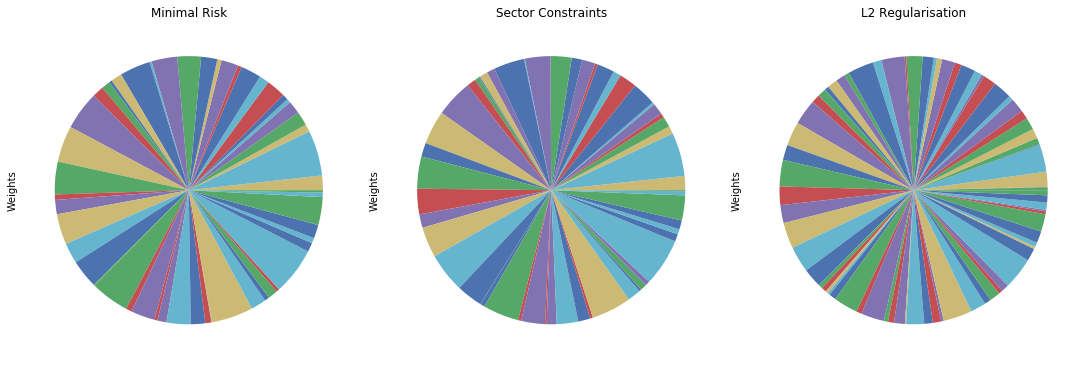

In [244]:
fig, axes  = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), constrained_layout=True)

efficient_frontiers_weights[index_best_efficient_frontier_sharpe]["Weights"].plot.pie(ax=axes[0], labels=None, title="Minimal Risk");
efficient_frontiers_sectors_weights[index_best_efficient_frontier_sharpe]["Weights"].plot.pie(ax=axes[1], labels = None, title="Sector Constraints");
efficient_frontiers_sectors_L2_weights[index_best_efficient_frontier_sharpe]["Weights"].plot.pie(ax=axes[2], labels = None, title="L2 Regularisation");

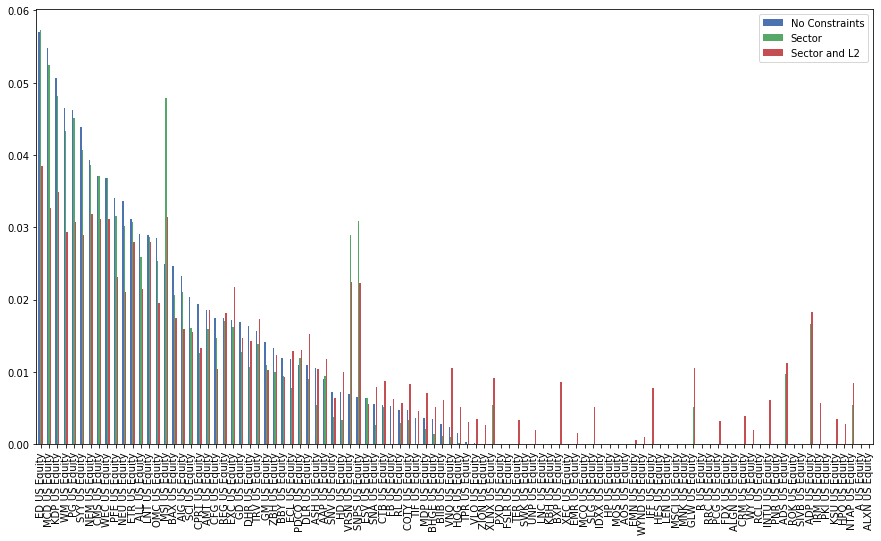

In [245]:
weights_across_portfolio = pd.DataFrame({"No Constraints": list(efficient_frontiers_weights[index_best_efficient_frontier_sharpe]["Weights"]),
                   "Sector": list(efficient_frontiers_sectors_weights[index_best_efficient_frontier_sharpe]["Weights"]),
                  "Sector and L2": list(efficient_frontiers_sectors_L2_weights[index_best_efficient_frontier_sharpe]["Weights"])}, 
index=list(random_portfolios[index_best_efficient_frontier_sharpe].columns))

ax = weights_across_portfolio.sort_values("No Constraints", ascending=False).plot.bar(figsize=(15, 8))

**Comparision of weights by sector**

In [246]:
no_constraints_weighted_dict = dict()
sector_constraints_weighted_dict = dict()
sector_L2_constraints_weighted_dict = dict()

for sector in set(sector_mapper.values()):
    total_weight = 0
    for t,w in efficient_frontiers_weights[index_best_efficient_frontier_sharpe]["Weights"].items():
        if sector_mapper[t] == sector:
            total_weight += w
    no_constraints_weighted_dict[sector] = total_weight
    
for sector in set(sector_mapper.values()):
    total_weight = 0
    for t,w in efficient_frontiers_sectors_weights[index_best_sector_sharpe]["Weights"].items():
        if sector_mapper[t] == sector:
            total_weight += w
    sector_constraints_weighted_dict[sector] = total_weight
    
for sector in set(sector_mapper.values()):
    total_weight = 0
    for t,w in efficient_frontiers_sectors_L2_weights[index_best_sector_L2_sharpe]["Weights"].items():
        if sector_mapper[t] == sector:
            total_weight += w
    sector_L2_constraints_weighted_dict[sector] = total_weight
    
df = pd.DataFrame([no_constraints_weighted_dict, sector_constraints_weighted_dict , sector_L2_constraints_weighted_dict],
                       index = ["Minimal Risk", "Sector Constraints", "Sector & L2 Constraints"] )
df

,Industrials,Consumer Staples,Financials,Communication Services,Information Technology,Real Estate,Healthcare,Consumer Discretionary,Utilities,Energy,Materials
Minimal Risk,0.08832,0.14556,0.09263,0.03730,0.03835,0.04927,0.10215,0.13316,0.20807,0.01003,0.09515
Sector Constraints,0.07121,0.13714,0.07911,0.02742,0.15000,0.04309,0.08588,0.10978,0.20680,0.00767,0.08190
Sector & L2 Constraints,0.05349,0.09957,0.18097,0.00147,0.15000,0.05515,0.10232,0.10031,0.19946,0.02792,0.02933


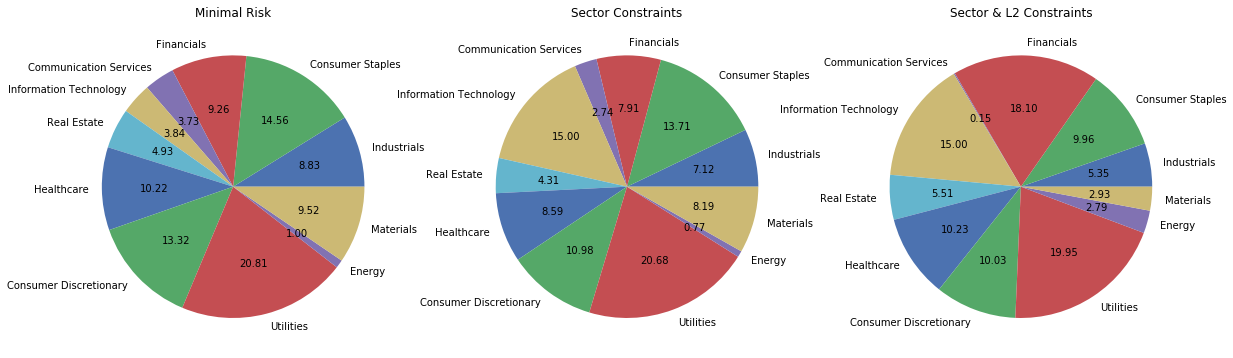

In [247]:
fig, axes = plt.subplots(1,3, figsize=(20,15))
for ax, idx in zip(axes, df.index):
    ax.pie(df.loc[idx], labels=df.columns, autopct="%.2f")
    ax.set(ylabel="", title=idx, aspect="equal")

plt.show();

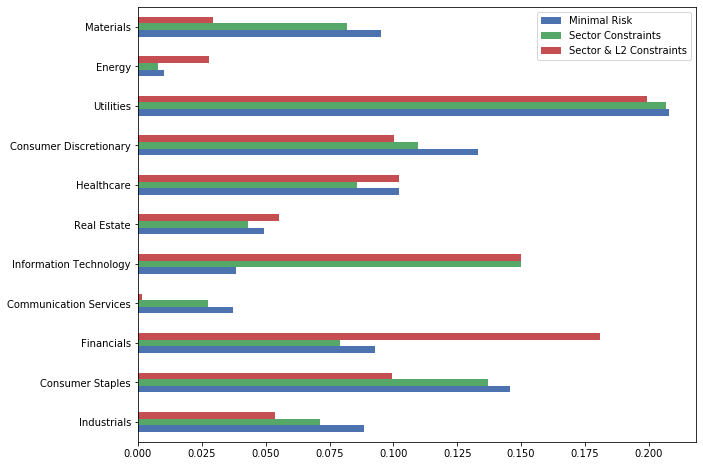

In [129]:
df.T.plot.barh(figsize=(10, 8));

In [13]:
# fig, axes  = plt.subplots(nrows=1, ncols=3, figsize=(20, 10), constrained_layout=True)

# sns.heatmap(efficient_frontiers[index_best_efficient_frontier_sharpe].cov_matrix, ax=axes[0]);
# sns.heatmap(efficient_frontiers_sectors[index_best_sector_sharpe].cov_matrix, ax=axes[1]);
# sns.heatmap(efficient_frontiers_sectors_L2[index_best_sector_L2_sharpe].cov_matrix, ax=axes[2]);

# Defensive stock constraint

If an economy is in a bear market whereby prices of stocks go down by 20% within a given time frame, then investors commonly place their assets into defensive sectors, such as consumer staples, healthcare and utilities.

Thus, lets see what happens when we change the sector mappings to that which place more emphasis on primarliy defensive stocks.

In [212]:
# Sectors without information have no lower bounds
sector_lower_defensive = {
    "Consumer Staples": 0.15,
#     "Information Technology": 0.05,
    "Healthcare": 0.05,
#     "Materials": 0.01,
    "Utilities": 0.15,
#     "Financials": 0.05,
#     "Real Estate": 0.025,
#     "Energy": 0.05,
#     "Communication Services": 0.05,
#     "Industrials": 0.05,
#     "Consumer Discretionary": 0.05
    
}

sector_upper_defensive = {
#     "Consumer Staples": 0.5, 
    "Information Technology": 0.02, 
#     "Healthcare": 0.5,
#     "Materials": 0.5,
#     "Utilities": 0.2,
#     "Financials": 0.15,
    "Real Estate": 0.02,
#     "Energy": 0.5,
    "Communication Services": 0.02,
#     "Industrials": 0.2,
    "Consumer Discretionary": 0.15
}

In [238]:
def_efficient_frontiers, def_efficient_frontiers_weights = [], []
def_efficient_frontiers_results = pd.DataFrame(columns=["Expected Return", "Volatility", "Sharpe Ratio"])

def_efficient_frontiers_sectors, def_efficient_frontiers_sectors_weights = [], []
def_efficient_frontiers_sectors_results = pd.DataFrame(columns=["Expected Return", "Volatility", "Sharpe Ratio"])

def_efficient_frontiers_sectors_L2, def_efficient_frontiers_sectors_L2_weights = [], []
def_efficient_frontiers_sectors_L2_results = pd.DataFrame(columns=["Expected Return", "Volatility", "Sharpe Ratio"])

for index, sample_portfolio in enumerate(random_portfolios):
    # Efficient Frontiers
    expected_return = mean_historical_return(sample_portfolio)
    covariance_matrix = CovarianceShrinkage(sample_portfolio).ledoit_wolf()
    efficient_frontier = EfficientFrontier(expected_return, covariance_matrix)
    _ = efficient_frontier.efficient_risk(target_volatility=0.15)
    
    _ = efficient_frontier.min_volatility()
    weights = efficient_frontier.clean_weights()
    
    def_efficient_frontiers.append(efficient_frontier)
    def_efficient_frontiers_weights.append(pd.DataFrame(weights.values(), columns=["Weights"], index=weights.keys()))
    def_efficient_frontiers_results.loc[index] = efficient_frontier.portfolio_performance(verbose=False)

    # Sector Contraints
    expected_return = mean_historical_return(sample_portfolio)
    covariance_matrix = CovarianceShrinkage(sample_portfolio).ledoit_wolf()
    efficient_frontier = EfficientFrontier(expected_return, covariance_matrix)
    efficient_frontier.add_sector_constraints(sector_mapper, sector_lower_defensive, sector_upper_defensive)
    _ = efficient_frontier.efficient_risk(target_volatility=0.15)
    
    _ = efficient_frontier.min_volatility()
    weights = efficient_frontier.clean_weights()
    
    def_efficient_frontiers_sectors.append(efficient_frontier)
    def_efficient_frontiers_sectors_weights.append(pd.DataFrame(weights.values(), columns=["Weights"], index=weights.keys()))
    def_efficient_frontiers_sectors_results.loc[index] = efficient_frontier.portfolio_performance(verbose=False)
    
    # Sector Contraints with L2 Regularisation
    expected_return = mean_historical_return(sample_portfolio)
    covariance_matrix = CovarianceShrinkage(sample_portfolio).ledoit_wolf()
    efficient_frontier = EfficientFrontier(expected_return, covariance_matrix)
    efficient_frontier.add_sector_constraints(sector_mapper, sector_lower_defensive, sector_upper_defensive)
    efficient_frontier.add_objective(objective_functions.L2_reg, gamma=0.1)  # Gamma is the tuning parameter
    _ = efficient_frontier.efficient_risk(target_volatility=0.15)
    
    _ = efficient_frontier.min_volatility()
    weights = efficient_frontier.clean_weights()
    
    def_efficient_frontiers_sectors_L2.append(efficient_frontier)
    def_efficient_frontiers_sectors_L2_weights.append(pd.DataFrame(weights.values(), columns=["Weights"], index=weights.keys()))
    def_efficient_frontiers_sectors_L2_results.loc[index] = efficient_frontier.portfolio_performance(verbose=False)

In [239]:
def_index_best_efficient_frontier_sharpe = def_efficient_frontiers_sectors_results["Sharpe Ratio"].argmax()
def_index_best_sector_sharpe = def_efficient_frontiers_sectors_results["Sharpe Ratio"].argmax()
def_index_best_sector_L2_sharpe = def_efficient_frontiers_sectors_L2_results["Sharpe Ratio"].argmax()

In [240]:
data.display_side_by_side(
[def_efficient_frontiers_results.sort_values("Volatility", ascending=True)[:3],
def_efficient_frontiers_sectors_results.sort_values("Volatility", ascending=True)[:3],
def_efficient_frontiers_sectors_L2_results.sort_values("Volatility", ascending=True)[:3]], ['Minimal Risk', 'Defensive Sectors', 'Defensive Sectors and L2'])

,Expected Return,Volatility,Sharpe Ratio
2,0.080989,0.069774,0.874093
20,0.070270,0.071344,0.704615
1,0.070372,0.072827,0.691667
,Expected Return,Volatility,Sharpe Ratio
2,0.081281,0.069868,0.877098
20,0.068317,0.071863,0.672359
1,0.068919,0.073340,0.667017
,Expected Return,Volatility,Sharpe Ratio
2,0.080040,0.072202,0.831551
20,0.066480,0.073665,0.630969


In [241]:
data.display_side_by_side(
[def_efficient_frontiers_results.sort_values("Sharpe Ratio", ascending=False)[:3],
def_efficient_frontiers_sectors_results.sort_values("Sharpe Ratio", ascending=False)[:3],
def_efficient_frontiers_sectors_L2_results.sort_values("Sharpe Ratio", ascending=False)[:3]], ['Minimal Risk', 'Defensive Sectors', 'Defensive Sectors and L2'])

,Expected Return,Volatility,Sharpe Ratio
41,0.087233,0.074492,0.902552
2,0.080989,0.069774,0.874093
38,0.093707,0.085696,0.860091
,Expected Return,Volatility,Sharpe Ratio
41,0.085628,0.074657,0.879059
2,0.081281,0.069868,0.877098
39,0.088264,0.083560,0.816944
,Expected Return,Volatility,Sharpe Ratio
2,0.080040,0.072202,0.831551
9,0.076125,0.076227,0.736292


In [242]:
# def_weights_across_portfolio = pd.DataFrame({"No Constraints": list(def_efficient_frontiers_weights[def_index_best_efficient_frontier_sharpe]["Weights"]),
#                    "Sector": list(def_efficient_frontiers_sectors_weights[def_index_best_efficient_frontier_sharpe]["Weights"]),
#                   "Sector and L2": list(def_efficient_frontiers_sectors_L2_weights[def_index_best_efficient_frontier_sharpe]["Weights"])}, 
# index=list(random_portfolios[def_index_best_efficient_frontier_sharpe].columns))

# ax = weights_across_portfolio.sort_values("No Constraints", ascending=False).plot.bar(figsize=(15, 8))

**Comparision of weights by sector**

In [210]:
def_no_constraints_weighted_dict = dict()
def_sector_constraints_weighted_dict = dict()
def_sector_L2_constraints_weighted_dict = dict()

for sector in set(sector_mapper.values()):
    total_weight = 0
    for t,w in def_efficient_frontiers_weights[def_index_best_efficient_frontier_sharpe]["Weights"].items():
        if sector_mapper[t] == sector:
            total_weight += w
    def_no_constraints_weighted_dict[sector] = total_weight
    
for sector in set(sector_mapper.values()):
    total_weight = 0
    for t,w in def_efficient_frontiers_sectors_weights[def_index_best_sector_sharpe]["Weights"].items():
        if sector_mapper[t] == sector:
            total_weight += w
    def_sector_constraints_weighted_dict[sector] = total_weight
    
for sector in set(sector_mapper.values()):
    total_weight = 0
    for t,w in efficient_frontiers_sectors_L2_weights[def_index_best_sector_L2_sharpe]["Weights"].items():
        if sector_mapper[t] == sector:
            total_weight += w
    def_sector_L2_constraints_weighted_dict[sector] = total_weight
    
df2 = pd.DataFrame([def_no_constraints_weighted_dict, def_sector_constraints_weighted_dict , def_sector_L2_constraints_weighted_dict],
                       index = ["Minimal Risk", "Sector Constraints", "Sector & L2 Constraints"] )
df2

,Industrials,Consumer Staples,Financials,Communication Services,Information Technology,Real Estate,Healthcare,Consumer Discretionary,Utilities,Energy,Materials
Minimal Risk,0.08832,0.14556,0.09263,0.03730,0.03835,0.04927,0.10215,0.13316,0.20807,0.01003,0.09515
Sector Constraints,0.09207,0.14942,0.09504,0.03001,0.03001,0.03001,0.10710,0.14035,0.21620,0.01089,0.09896
Sector & L2 Constraints,0.05349,0.09957,0.18097,0.00147,0.15000,0.05515,0.10232,0.10031,0.19946,0.02792,0.02933


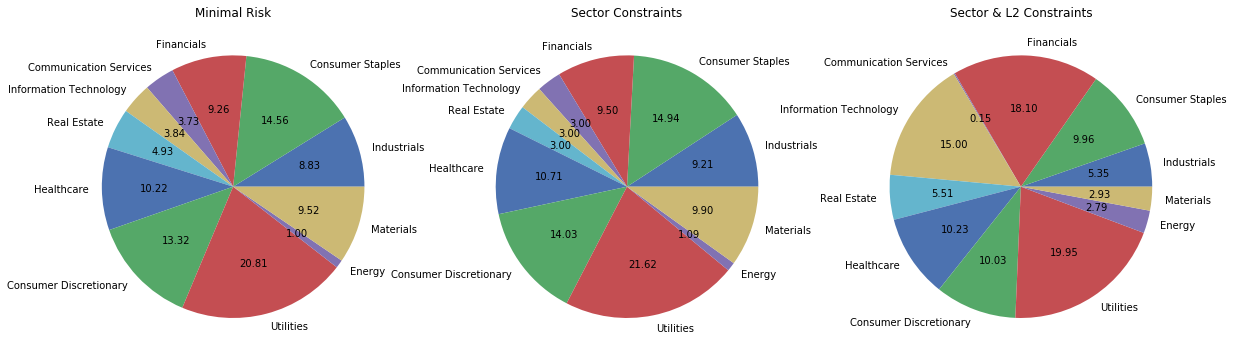

In [211]:
fig, axes = plt.subplots(1,3, figsize=(20,15))
for ax, idx in zip(axes, df2.index):
    ax.pie(df2.loc[idx], labels=df2.columns, autopct="%.2f")
    ax.set(ylabel="", title=idx, aspect="equal")

plt.show();

## High Consumer Confidence

Now, lets place minimums on stocks which do well in a bull market.

In [21]:
# Sectors without information have no lower bounds
sector_lower_bull = {
#     "Consumer Staples": 0.05,
#     "Information Technology": 0.05,
#     "Healthcare": 0.10,
    "Materials": 0.15,
#     "Utilities": 0.05,
    "Financials": 0.15,
#     "Real Estate": 0.025,
#     "Energy": 0.05,
#     "Communication Services": 0.05,
#     "Industrials": 0.05,
    "Consumer Discretionary": 0.15
    
}

sector_upper_bull = {
#     "Consumer Staples": 0.5, 
#     "Information Technology": 0.05, 
#     "Healthcare": 0.5,
#     "Materials": 0.5,
#     "Utilities": 0.2,
#     "Financials": 0.5,
#     "Real Estate": 0.2,
#     "Energy": 0.5,
#     "Communication Services": 0.5,
#     "Industrials": 0.2,
#     "Consumer Discretionary": 0.05
}

In [22]:
bull_efficient_frontiers, bull_efficient_frontiers_weights = [], []
bull_efficient_frontiers_results = pd.DataFrame(columns=["Expected Return", "Volatility", "Sharpe Ratio"])

bull_efficient_frontiers_sectors, bull_efficient_frontiers_sectors_weights = [], []
bull_efficient_frontiers_sectors_results = pd.DataFrame(columns=["Expected Return", "Volatility", "Sharpe Ratio"])

bull_efficient_frontiers_sectors_L2, bull_efficient_frontiers_sectors_L2_weights = [], []
bull_efficient_frontiers_sectors_L2_results = pd.DataFrame(columns=["Expected Return", "Volatility", "Sharpe Ratio"])

for index, sample_portfolio in enumerate(random_portfolios):
    # Efficient Frontiers
    expected_return = mean_historical_return(sample_portfolio)
    covariance_matrix = CovarianceShrinkage(sample_portfolio).ledoit_wolf()
    efficient_frontier = EfficientFrontier(expected_return, covariance_matrix)
    _ = efficient_frontier.efficient_risk(target_volatility=0.15)
    
    _ = efficient_frontier.min_volatility()
    weights = efficient_frontier.clean_weights()
    
    bull_efficient_frontiers.append(efficient_frontier)
    bull_efficient_frontiers_weights.append(pd.DataFrame(weights.values(), columns=["Weights"], index=weights.keys()))
    bull_efficient_frontiers_results.loc[index] = efficient_frontier.portfolio_performance(verbose=False)

    # Sector Contraints
    expected_return = mean_historical_return(sample_portfolio)
    covariance_matrix = CovarianceShrinkage(sample_portfolio).ledoit_wolf()
    efficient_frontier = EfficientFrontier(expected_return, covariance_matrix)
    efficient_frontier.add_sector_constraints(sector_mapper, sector_lower_bull, sector_upper_bull)
    _ = efficient_frontier.efficient_risk(target_volatility=0.15)
    
    _ = efficient_frontier.min_volatility()
    weights = efficient_frontier.clean_weights()
    
    bull_efficient_frontiers_sectors.append(efficient_frontier)
    bull_efficient_frontiers_sectors_weights.append(pd.DataFrame(weights.values(), columns=["Weights"], index=weights.keys()))
    bull_efficient_frontiers_sectors_results.loc[index] = efficient_frontier.portfolio_performance(verbose=False)
    
    # Sector Contraints with L2 Regularisation
    expected_return = mean_historical_return(sample_portfolio)
    covariance_matrix = CovarianceShrinkage(sample_portfolio).ledoit_wolf()
    efficient_frontier = EfficientFrontier(expected_return, covariance_matrix)
    efficient_frontier.add_sector_constraints(sector_mapper, sector_lower_bull, sector_upper_bull)
    efficient_frontier.add_objective(objective_functions.L2_reg, gamma=0.1)  # Gamma is the tuning parameter
#     _ = efficient_frontier.efficient_risk(0.15)    

    _ = efficient_frontier.min_volatility()
    weights = efficient_frontier.clean_weights()
    
    bull_efficient_frontiers_sectors_L2.append(efficient_frontier)
    bull_efficient_frontiers_sectors_L2_weights.append(pd.DataFrame(weights.values(), columns=["Weights"], index=weights.keys()))
    bull_efficient_frontiers_sectors_L2_results.loc[index] = efficient_frontier.portfolio_performance(verbose=False)

In [23]:
bull_index_best_efficient_frontier_sharpe = bull_efficient_frontiers_sectors_results["Sharpe Ratio"].argmax()
bull_index_best_sector_sharpe = bull_efficient_frontiers_sectors_results["Sharpe Ratio"].argmax()
bull_index_best_sector_L2_sharpe = bull_efficient_frontiers_sectors_L2_results["Sharpe Ratio"].argmax()

In [24]:
data.display_side_by_side(
[bull_efficient_frontiers_results.sort_values("Sharpe Ratio", ascending=False)[:3],
bull_efficient_frontiers_sectors_results.sort_values("Sharpe Ratio", ascending=False)[:3],
bull_efficient_frontiers_sectors_L2_results.sort_values("Sharpe Ratio", ascending=False)[:3]], ["No Constraints", "Bullish Sectors", "Bullish Sectors and L2"])

,Expected Return,Volatility,Sharpe Ratio
41,0.087233,0.074492,0.902552
2,0.080989,0.069774,0.874093
38,0.093707,0.085696,0.860091
,Expected Return,Volatility,Sharpe Ratio
2,0.082795,0.071035,0.884005
38,0.096299,0.086483,0.882234
41,0.085804,0.075100,0.876222
,Expected Return,Volatility,Sharpe Ratio
2,0.080912,0.073475,0.829023
41,0.073811,0.077979,0.690060


We can examine the weights of portfolio 11

**Comparision of weights by sector**

In [123]:
bull_no_constraints_weighted_dict = dict()
bull_sector_constraints_weighted_dict = dict()
bull_sector_L2_constraints_weighted_dict = dict()

for sector in set(sector_mapper.values()):
    total_weight = 0
    for t,w in bull_efficient_frontiers_weights[bull_index_best_efficient_frontier_sharpe]["Weights"].items():
        if sector_mapper[t] == sector:
            total_weight += w
    bull_no_constraints_weighted_dict[sector] = total_weight
    
for sector in set(sector_mapper.values()):
    total_weight = 0
    for t,w in bull_efficient_frontiers_sectors_weights[bull_index_best_sector_sharpe]["Weights"].items():
        if sector_mapper[t] == sector:
            total_weight += w
    bull_sector_constraints_weighted_dict[sector] = total_weight
    
for sector in set(sector_mapper.values()):
    total_weight = 0
    for t,w in efficient_frontiers_sectors_L2_weights[bull_index_best_sector_L2_sharpe]["Weights"].items():
        if sector_mapper[t] == sector:
            total_weight += w
    bull_sector_L2_constraints_weighted_dict[sector] = total_weight
    
df3 = pd.DataFrame([bull_no_constraints_weighted_dict, bull_sector_constraints_weighted_dict , bull_sector_L2_constraints_weighted_dict],
                       index = ["Minimal Risk", "Sector Constraints", "Sector & L2 Constraints"] )
df3 = df3[['Industrials',
  'Information Technology',
  'Consumer Staples',
 'Financials',
 'Communication Services',
 'Real Estate',
 'Healthcare',
 'Consumer Discretionary',
 'Utilities',
 'Energy',
 'Materials']]

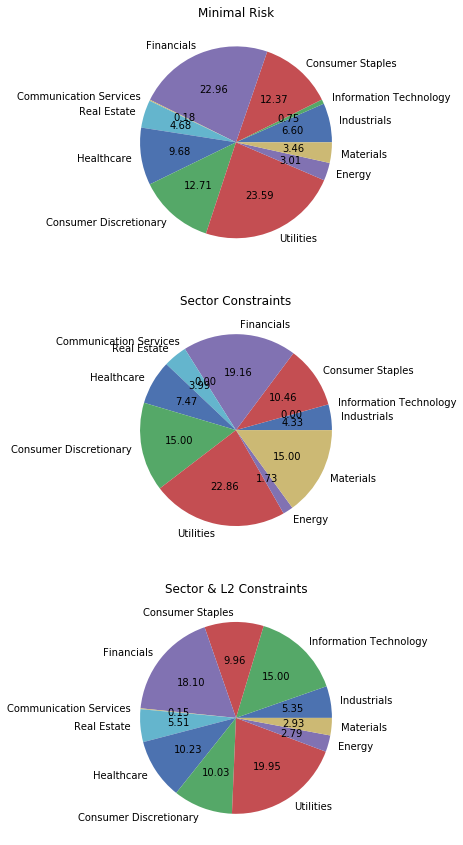

In [124]:
fig, axes = plt.subplots(3,1, figsize=(15,15))
for ax, idx in zip(axes, df3.index):
    ax.pie(df3.loc[idx], labels=df3.columns, autopct="%.2f")
    ax.set(ylabel="", title=idx, aspect="equal")

plt.show();


# Comparing Weights and Results
To measure how well our models are doing we can compare the distribution of stocks in each portfolio.
We will be able to use matrix covariance and weight percentage bar graphs to tell this story.


Stocks with higher correlations will be less diversified and so should be brighter on the covariance matrix.

### Overall Best Expected Annual Return

In [251]:
print("\n Top performing portfolios sorted by highest sharpe ratios")


data.display_side_by_side(
[efficient_frontiers_results.sort_values("Sharpe Ratio", ascending=False)[:3],
efficient_frontiers_sectors_results.sort_values("Sharpe Ratio", ascending=False)[:3],
efficient_frontiers_sectors_L2_results.sort_values("Sharpe Ratio", ascending=False)[:3]], ["Minimal Risk", "Sectors", "Sectors and L2"])

data.display_side_by_side(
[def_efficient_frontiers_results.sort_values("Sharpe Ratio", ascending=False)[:3],
def_efficient_frontiers_sectors_results.sort_values("Sharpe Ratio", ascending=False)[:3],
def_efficient_frontiers_sectors_L2_results.sort_values("Sharpe Ratio", ascending=False)[:3]], ["Minimal Risk", "Defensive Sectors", "Defensive Sectors and L2"])

data.display_side_by_side(
[bull_efficient_frontiers_results.sort_values("Sharpe Ratio", ascending=False)[:3],
bull_efficient_frontiers_sectors_results.sort_values("Sharpe Ratio", ascending=False)[:3],
bull_efficient_frontiers_sectors_L2_results.sort_values("Sharpe Ratio", ascending=False)[:3]], ["Minimal Risk", "Bullish Sectors", "Bullish Sectors and L2"])


 Top performing portfolios sorted by highest sharpe ratios


,Expected Return,Volatility,Sharpe Ratio
41,0.087233,0.074492,0.902552
2,0.080989,0.069774,0.874093
38,0.093707,0.085696,0.860091
,Expected Return,Volatility,Sharpe Ratio
41,0.093793,0.075409,0.978569
2,0.085096,0.071202,0.914245
34,0.085784,0.077133,0.852863
,Expected Return,Volatility,Sharpe Ratio
2,0.085601,0.072390,0.906214
41,0.081946,0.076758,0.807022


,Expected Return,Volatility,Sharpe Ratio
41,0.087233,0.074492,0.902552
2,0.080989,0.069774,0.874093
38,0.093707,0.085696,0.860091
,Expected Return,Volatility,Sharpe Ratio
41,0.085628,0.074657,0.879059
2,0.081281,0.069868,0.877098
39,0.088264,0.083560,0.816944
,Expected Return,Volatility,Sharpe Ratio
2,0.080040,0.072202,0.831551
9,0.076125,0.076227,0.736292


,Expected Return,Volatility,Sharpe Ratio
41,0.087233,0.074492,0.902552
2,0.080989,0.069774,0.874093
38,0.093707,0.085696,0.860091
,Expected Return,Volatility,Sharpe Ratio
2,0.082795,0.071035,0.884005
38,0.096299,0.086483,0.882234
41,0.085804,0.075100,0.876222
,Expected Return,Volatility,Sharpe Ratio
2,0.080912,0.073475,0.829023
41,0.073811,0.077979,0.690060


In [255]:
print("\n Top performing portfolios sorted by highest expected return")

data.display_side_by_side(
[efficient_frontiers_results.sort_values("Expected Return", ascending=False)[:3],
efficient_frontiers_sectors_results.sort_values("Expected Return", ascending=False)[:3],
efficient_frontiers_sectors_L2_results.sort_values("Expected Return", ascending=False)[:3]], ["Minimal Risk", "Uncorrelated Sectors", "Sectors and L2"])

data.display_side_by_side(
[def_efficient_frontiers_results.sort_values("Expected Return", ascending=False)[:3],
def_efficient_frontiers_sectors_results.sort_values("Expected Return", ascending=False)[:3],
def_efficient_frontiers_sectors_L2_results.sort_values("Expected Return", ascending=False)[:3]], ["Minimal Risk", "Defensive Sectors", "Defensive Sectors and L2"])

data.display_side_by_side(
[bull_efficient_frontiers_results.sort_values("Expected Return", ascending=False)[:3],
bull_efficient_frontiers_sectors_results.sort_values("Expected Return", ascending=False)[:3],
bull_efficient_frontiers_sectors_L2_results.sort_values("Expected Return", ascending=False)[:3]], ["Minimal Risk", "Bullish Sectors", "Bullish Sectors and L2"])


 Top performing portfolios sorted by highest expected return


,Expected Return,Volatility,Sharpe Ratio
38,0.093707,0.085696,0.860091
39,0.088672,0.083105,0.826322
41,0.087233,0.074492,0.902552
,Expected Return,Volatility,Sharpe Ratio
41,0.093793,0.075409,0.978569
38,0.091540,0.086317,0.828802
39,0.089652,0.084799,0.821373
,Expected Return,Volatility,Sharpe Ratio
2,0.085601,0.072390,0.906214
4,0.085545,0.090984,0.720401


,Expected Return,Volatility,Sharpe Ratio
38,0.093707,0.085696,0.860091
39,0.088672,0.083105,0.826322
41,0.087233,0.074492,0.902552
,Expected Return,Volatility,Sharpe Ratio
38,0.090468,0.086338,0.816190
39,0.088264,0.083560,0.816944
3,0.086339,0.086362,0.768147
,Expected Return,Volatility,Sharpe Ratio
2,0.080040,0.072202,0.831551
0,0.078201,0.090212,0.645153


,Expected Return,Volatility,Sharpe Ratio
38,0.093707,0.085696,0.860091
39,0.088672,0.083105,0.826322
41,0.087233,0.074492,0.902552
,Expected Return,Volatility,Sharpe Ratio
38,0.096299,0.086483,0.882234
0,0.088285,0.088478,0.771779
3,0.087204,0.087629,0.766908
,Expected Return,Volatility,Sharpe Ratio
2,0.080912,0.073475,0.829023
38,0.079588,0.091903,0.648373


In [73]:
efficient_frontiers_sectors_results.iloc[38]
def_efficient_frontiers_sectors_results.iloc[38]
bull_efficient_frontiers_sectors_results.iloc[38]

Expected Return    0.091540
Volatility         0.086317
Sharpe Ratio       0.828802
Name: 38, dtype: float64

Expected Return    0.083528
Volatility         0.086817
Sharpe Ratio       0.731749
Name: 38, dtype: float64

Expected Return    0.096299
Volatility         0.086483
Sharpe Ratio       0.882234
Name: 38, dtype: float64

In [107]:
sample_port = dict()

for sector in set(sector_mapper.values()):
    total_weight = 0
    for t,w in efficient_frontiers_sectors_weights[38]["Weights"].items():
        if sector_mapper[t] == sector:
            total_weight += w
    sample_port[sector] = total_weight

res1 = pd.DataFrame.from_dict(data=sample_port,orient='index')
res1.rename(columns={0:"Uncorrelated Sectors"}, inplace=True)

sample_port = dict()

for sector in set(sector_mapper.values()):
    total_weight = 0
    for t,w in def_efficient_frontiers_sectors_weights[38]["Weights"].items():
        if sector_mapper[t] == sector:
            total_weight += w
    sample_port[sector] = total_weight

res2 = pd.DataFrame.from_dict(data=sample_port,orient='index')
res2.rename(columns={0:"Defensive Sectors"}, inplace=True)

sample_port = dict()

for sector in set(sector_mapper.values()):
    total_weight = 0
    for t,w in bull_efficient_frontiers_sectors_weights[38]["Weights"].items():
        if sector_mapper[t] == sector:
            total_weight += w
    sample_port[sector] = total_weight

res3 = pd.DataFrame.from_dict(data=sample_port,orient='index')
res3.rename(columns={0:"Bull-market Sectors"}, inplace=True)

combined = pd.concat([res1.T,res2.T,res3.T])

In [108]:
combined

,Industrials,Consumer Staples,Financials,Communication Services,Information Technology,Real Estate,Healthcare,Consumer Discretionary,Utilities,Energy,Materials
Uncorrelated Sectors,0.15112,0.07497,0.08480,0.0,0.14999,0.07852,0.05796,0.12801,0.22420,0.00299,0.04741
Defensive Sectors,0.14757,0.20000,0.09575,0.0,0.04533,0.06531,0.10000,0.10000,0.18546,0.00632,0.05425
Bull-market Sectors,0.14049,0.05729,0.15000,0.0,0.02076,0.06771,0.04396,0.15001,0.21643,0.00335,0.15001


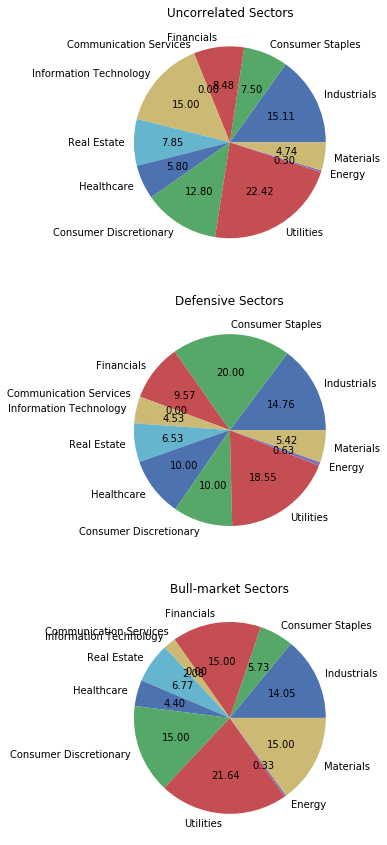

In [109]:
fig, axes = plt.subplots(3,1, figsize=(15,15))
for ax, idx in zip(axes, combined.index):
    ax.pie(combined.loc[idx], labels=combined.columns, autopct="%.2f")
    ax.set(ylabel="", title=idx, aspect="equal")

plt.show();

In [110]:
combined.loc["Uncorrelated Sectors"]

Industrials               0.15112
Consumer Staples          0.07497
Financials                0.08480
Communication Services    0.00000
Information Technology    0.14999
Real Estate               0.07852
Healthcare                0.05796
Consumer Discretionary    0.12801
Utilities                 0.22420
Energy                    0.00299
Materials                 0.04741
Name: Uncorrelated Sectors, dtype: float64

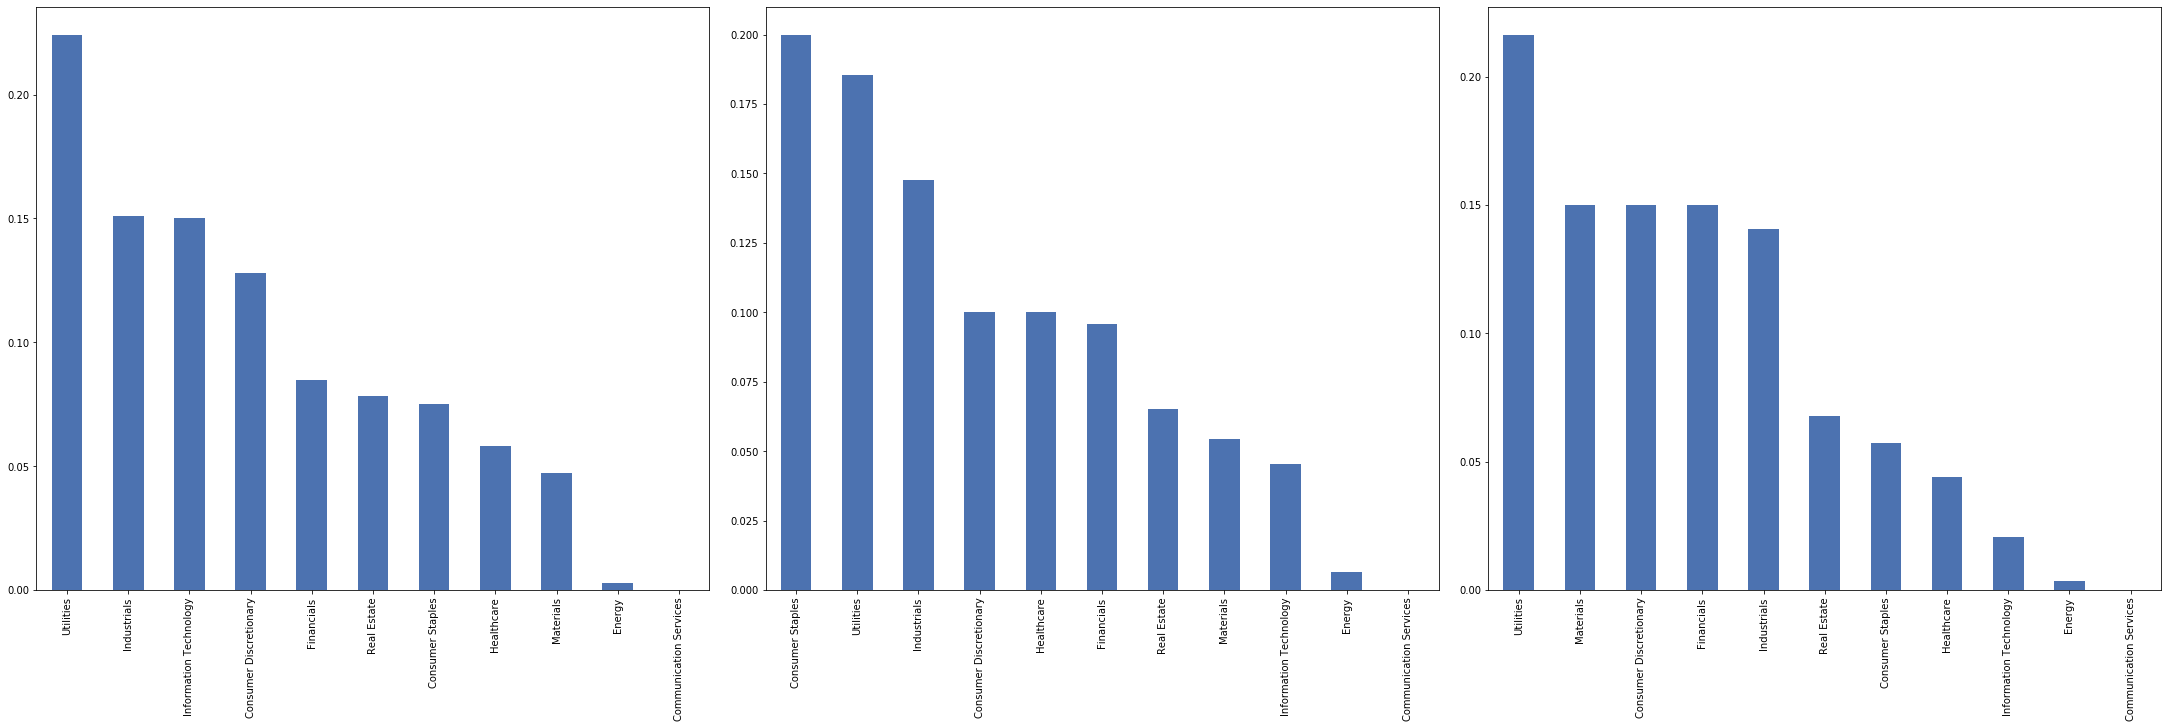

In [111]:
fig, axes  = plt.subplots(nrows=1, ncols=3, figsize=(30, 10), constrained_layout=True)

combined.loc["Uncorrelated Sectors"].sort_values(ascending=False).plot.bar(ax=axes[0]);
combined.loc["Defensive Sectors"].sort_values(ascending=False).plot.bar(ax=axes[1]);
combined.loc["Bull-market Sectors"].sort_values(ascending=False).plot.bar(ax=axes[2]);

In [254]:
print("\n Top performing portfolios sorted by lowest volatility")

data.display_side_by_side(
[efficient_frontiers_results.sort_values("Volatility", ascending=True)[:3],
efficient_frontiers_sectors_results.sort_values("Volatility", ascending=True)[:3],
efficient_frontiers_sectors_L2_results.sort_values("Volatility", ascending=True)[:3]], ["Minimal Risk", "Uncorrelated Sectors", "Sectors and L2"])

# data.display_side_by_side(
# [def_efficient_frontiers_results.sort_values("Volatility", ascending=True)[:3],
# def_efficient_frontiers_sectors_results.sort_values("Volatility", ascending=True)[:3],
# def_efficient_frontiers_sectors_L2_results.sort_values("Volatility", ascending=True)[:3]], ["Minimal Risk", "Defensive Sectors", "Defensive Sectors and L2"])

data.display_side_by_side(
[def_efficient_frontiers_results.sort_values("Volatility", ascending=True)[:3],
def_efficient_frontiers_sectors_results.sort_values("Volatility", ascending=True)[:3],
def_efficient_frontiers_sectors_L2_results.sort_values("Volatility", ascending=True)[:3]], ['Minimal Risk', 'Defensive Sectors', 'Defensive Sectors and L2'])

data.display_side_by_side(
[bull_efficient_frontiers_results.sort_values("Volatility", ascending=True)[:3],
bull_efficient_frontiers_sectors_results.sort_values("Volatility", ascending=True)[:3],
bull_efficient_frontiers_sectors_L2_results.sort_values("Volatility", ascending=True)[:3]], ["Minimal Risk", "Bullish Sectors", "Bullish Sectors and L2"])


 Top performing portfolios sorted by lowest volatility


,Expected Return,Volatility,Sharpe Ratio
2,0.080989,0.069774,0.874093
20,0.070270,0.071344,0.704615
1,0.070372,0.072827,0.691667
,Expected Return,Volatility,Sharpe Ratio
2,0.085096,0.071202,0.914245
20,0.075212,0.072107,0.765694
1,0.072132,0.073416,0.710091
,Expected Return,Volatility,Sharpe Ratio
2,0.085601,0.072390,0.906214
20,0.073677,0.073012,0.735180


,Expected Return,Volatility,Sharpe Ratio
2,0.080989,0.069774,0.874093
20,0.070270,0.071344,0.704615
1,0.070372,0.072827,0.691667
,Expected Return,Volatility,Sharpe Ratio
2,0.081281,0.069868,0.877098
20,0.068317,0.071863,0.672359
1,0.068919,0.073340,0.667017
,Expected Return,Volatility,Sharpe Ratio
2,0.080040,0.072202,0.831551
20,0.066480,0.073665,0.630969


,Expected Return,Volatility,Sharpe Ratio
2,0.080989,0.069774,0.874093
20,0.070270,0.071344,0.704615
1,0.070372,0.072827,0.691667
,Expected Return,Volatility,Sharpe Ratio
2,0.082795,0.071035,0.884005
20,0.066437,0.072609,0.639549
1,0.069839,0.074198,0.671701
,Expected Return,Volatility,Sharpe Ratio
2,0.080912,0.073475,0.829023
20,0.062973,0.074764,0.574783


In [100]:
index_best_efficient_frontier_return = efficient_frontiers_results["Expected Return"].argmax()
index_best_sector_return = efficient_frontiers_sectors_results["Expected Return"].argmax()
index_best_sector_L2_return = efficient_frontiers_sectors_L2_results["Expected Return"].argmax()

The figure below demonstrates the distinct diversity of stocks after sector constraints and regularisation methods are placed.

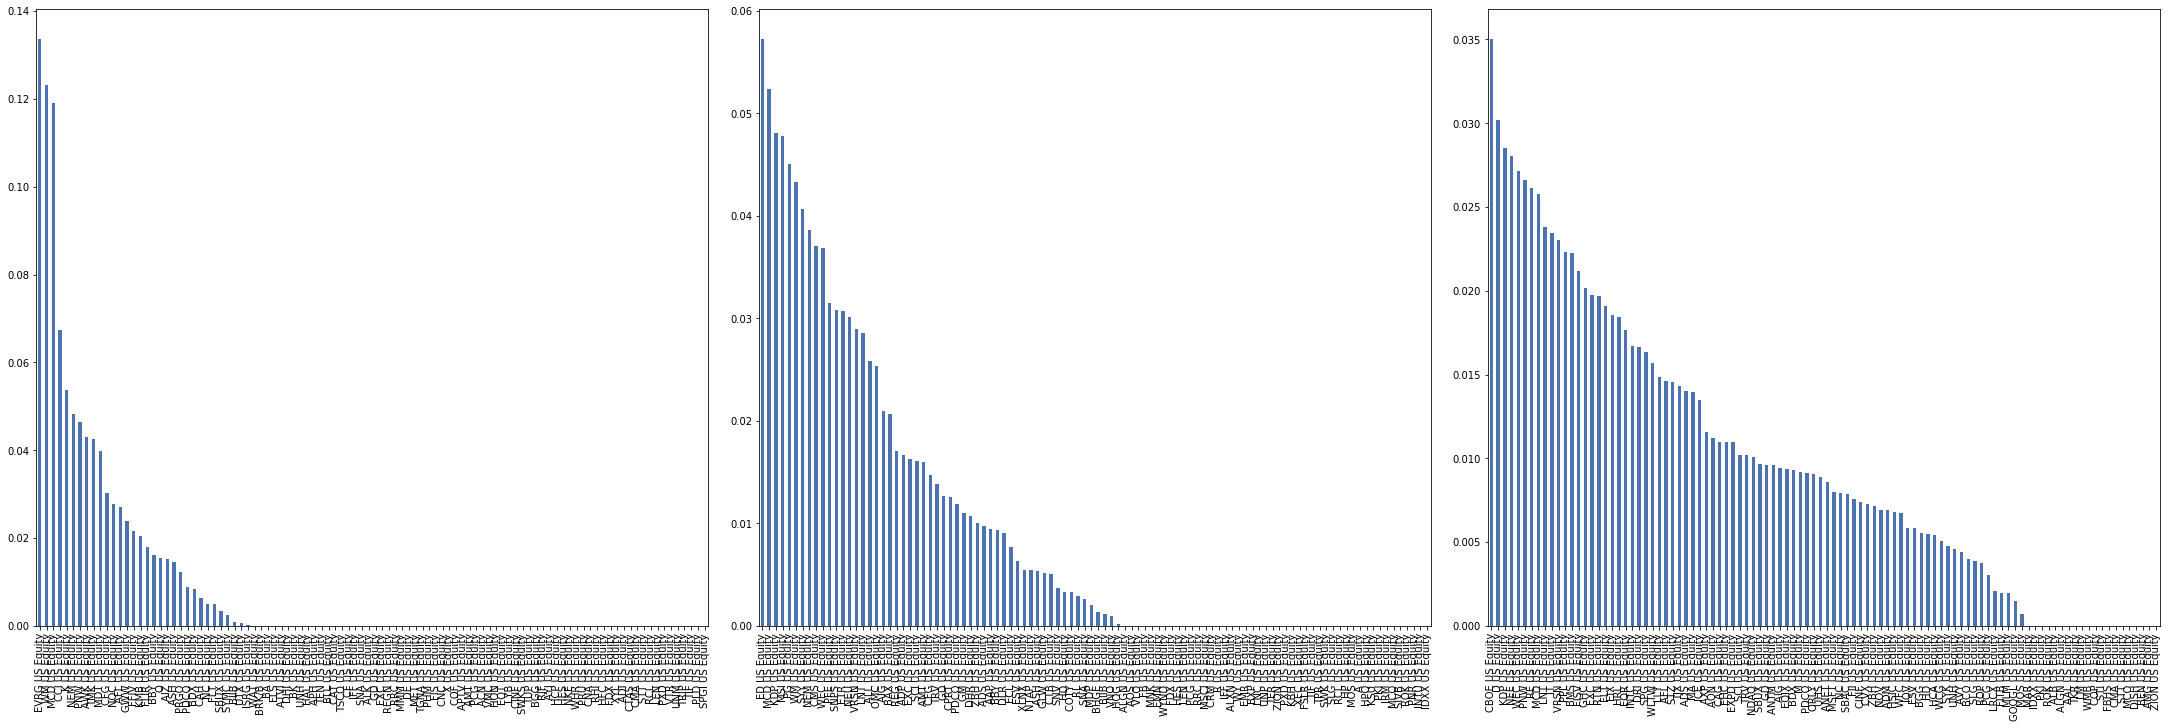

In [101]:
fig, axes  = plt.subplots(nrows=1, ncols=3, figsize=(30, 10), constrained_layout=True)

efficient_frontiers_weights[index_best_efficient_frontier_return]["Weights"].sort_values(ascending=False).plot.bar(ax=axes[0]);
efficient_frontiers_sectors_weights[index_best_sector_return]["Weights"].sort_values(ascending=False).plot.bar(ax=axes[1]);
efficient_frontiers_sectors_L2_weights[index_best_sector_L2_return]["Weights"].sort_values(ascending=False).plot.bar(ax=axes[2]);

Efficient Frontier

In [263]:
p = list(efficient_frontiers_weights[index_best_efficient_frontier_return]["Weights"]);

num_small = len([i for i in range(len(p)) if p[i] <= 1e-4])
print(f"{num_small}/{len(list(random_portfolios[0].columns))} tickers have zero weight")

68/100 tickers have zero weight


In [264]:
q = list(efficient_frontiers_sectors_weights[index_best_sector_return]["Weights"]);

num_small = len([i for i in range(len(q)) if q[i] <= 1e-9])
print(f"{num_small}/{len(list(random_portfolios[0].columns))} tickers have zero weight")

46/100 tickers have zero weight


In [266]:
r = list(efficient_frontiers_sectors_L2_weights[index_best_sector_L2_return]["Weights"]);

num_small = len([i for i in range(len(r)) if r[i] <= 1e-9])
print(f"{num_small}/{len(list(random_portfolios[0].columns))} tickers have zero weight")

20/100 tickers have zero weight


In [253]:
print("\n Top performing portfolios sorted by highest Sharpe Ratio")

data.display_side_by_side(
[efficient_frontiers_results.sort_values("Sharpe Ratio", ascending=False)[:3],
efficient_frontiers_sectors_results.sort_values("Sharpe Ratio", ascending=False)[:3],
efficient_frontiers_sectors_L2_results.sort_values("Sharpe Ratio", ascending=False)[:3]], ["Minimal Risk", "Uncorrelated Sectors", "Sectors and L2"])

data.display_side_by_side(
[def_efficient_frontiers_results.sort_values("Sharpe Ratio", ascending=False)[:3],
def_efficient_frontiers_sectors_results.sort_values("Sharpe Ratio", ascending=False)[:3],
def_efficient_frontiers_sectors_L2_results.sort_values("Sharpe Ratio", ascending=False)[:3]], ["Minimal Risk", "Defensive Sectors", "Defensive Sectors and L2"])

data.display_side_by_side(
[bull_efficient_frontiers_results.sort_values("Sharpe Ratio", ascending=False)[:3],
bull_efficient_frontiers_sectors_results.sort_values("Sharpe Ratio", ascending=False)[:3],
bull_efficient_frontiers_sectors_L2_results.sort_values("Sharpe Ratio", ascending=False)[:3]], ["Minimal Risk", "Bullish Sectors", "Bullish Sectors and L2"])


 Top performing portfolios sorted by highest Sharpe Ratio


,Expected Return,Volatility,Sharpe Ratio
41,0.087233,0.074492,0.902552
2,0.080989,0.069774,0.874093
38,0.093707,0.085696,0.860091
,Expected Return,Volatility,Sharpe Ratio
41,0.093793,0.075409,0.978569
2,0.085096,0.071202,0.914245
34,0.085784,0.077133,0.852863
,Expected Return,Volatility,Sharpe Ratio
2,0.085601,0.072390,0.906214
41,0.081946,0.076758,0.807022


,Expected Return,Volatility,Sharpe Ratio
41,0.087233,0.074492,0.902552
2,0.080989,0.069774,0.874093
38,0.093707,0.085696,0.860091
,Expected Return,Volatility,Sharpe Ratio
41,0.085628,0.074657,0.879059
2,0.081281,0.069868,0.877098
39,0.088264,0.083560,0.816944
,Expected Return,Volatility,Sharpe Ratio
2,0.080040,0.072202,0.831551
9,0.076125,0.076227,0.736292


,Expected Return,Volatility,Sharpe Ratio
41,0.087233,0.074492,0.902552
2,0.080989,0.069774,0.874093
38,0.093707,0.085696,0.860091
,Expected Return,Volatility,Sharpe Ratio
2,0.082795,0.071035,0.884005
38,0.096299,0.086483,0.882234
41,0.085804,0.075100,0.876222
,Expected Return,Volatility,Sharpe Ratio
2,0.080912,0.073475,0.829023
41,0.073811,0.077979,0.690060


In [218]:
a = list(efficient_frontiers_results["Expected Return"])
b = list(efficient_frontiers_results["Volatility"])

In [225]:
random_portfolios[38]

,SPGI US Equity,MCD US Equity,MDT US Equity,O US Equity,CAT US Equity,EVRG US Equity,TSCO US Equity,CF US Equity,FLT US Equity,CFG US Equity,IFF US Equity,SNA US Equity,BBY US Equity,GWW US Equity,PNW US Equity,ALK US Equity,BLL US Equity,GD US Equity,REGN US Equity,RRC US Equity,UTX US Equity,BIIB US Equity,MMM US Equity,DE US Equity,MET US Equity,TGNA US Equity,EXC US Equity,TEN US Equity,HAL US Equity,BRK/B US Equity,CAH US Equity,DHI US Equity,BK US Equity,UNH US Equity,BA US Equity,ATVI US Equity,FLS US Equity,WAT US Equity,PHM US Equity,SBUX US Equity,CNC US Equity,X US Equity,RHI US Equity,HFC US Equity,NOC US Equity,FDX US Equity,XYL US Equity,ADI US Equity,CTAS US Equity,FIS US Equity,CMA US Equity,CNA US Equity,AIZ US Equity,STT US Equity,TMK US Equity,KMB US Equity,LEN US Equity,FFIV US Equity,PXD US Equity,VTR US Equity,WM US Equity,UNM US Equity,TRIP US Equity,TIF US Equity,PLD US Equity,NEM US Equity,RCL US Equity,PRU US Equity,AFL US Equity,NC US Equity,AWK US Equity,WHR US Equity,NKE US Equity,COF US Equity,CCI US Equity,APTV US Equity,AMT US Equity,PCG US Equity,ACN US Equity,VMC US Equity,FLIR US Equity,HON US Equity,K US Equity,EQT US Equity,LYB US Equity,PDCO US Equity,BDX US Equity,ASH US Equity,CINF US Equity,SWKS US Equity,PRGO US Equity,TUP US Equity,BGG US Equity,RJF US Equity,AYI US Equity,HCP US Equity,SYMC US Equity,HES US Equity,ISRG US Equity,APH US Equity
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-01,85.034,84.062,66.7104,40.2348,80.4493,36.5423,75.0455,47.7667,148.71,22.9963,94.311,127.584,34.3585,233.848,59.4340,56.1530,33.0298,127.557,410.25,52.6960,104.507,312.668,148.412,80.8919,42.3090,15.0055,32.0569,54.7704,36.9306,150.15,73.6487,24.2643,37.7510,95.332,116.995,19.5636,56.2867,112.72,20.2271,38.2908,51.925,25.7227,54.2325,32.5965,138.801,168.3799,36.0440,50.6704,74.8761,59.0017,43.8911,28.5517,62.9787,72.9513,52.4781,102.5111,44.1522,130.465,148.341,51.9773,46.6970,32.0178,74.66,98.7945,37.9776,18.3825,76.5887,80.2862,27.7681,12.6955,48.9155,175.161,46.0065,76.3231,67.8230,57.7397,91.634,48.6786,82.5111,63.823,30.5056,87.5378,58.5444,40.8420,68.9892,43.3582,131.319,55.7516,45.7891,69.3245,163.1218,52.2421,18.5024,54.5631,138.433,31.9368,19.2773,68.7570,176.313,51.9673
2015-01-02,84.728,83.667,66.4148,41.0022,80.7569,36.4802,74.3314,48.7061,150.26,22.9038,93.836,127.164,34.1910,234.150,59.7211,56.6886,33.0976,128.327,410.16,54.6185,104.543,315.026,148.178,80.7730,42.1682,14.4086,32.4806,54.3834,37.0808,149.17,73.4480,23.9476,37.6486,95.040,116.968,19.5442,56.1174,113.88,20.0386,38.0061,52.220,25.5784,53.7680,33.4314,137.926,167.2066,36.0534,50.6886,74.8856,59.2009,43.3758,28.3747,62.3713,72.8119,52.4684,102.5199,43.6398,130.330,149.377,53.1444,47.0882,31.8893,74.59,97.5372,38.3306,18.8105,77.0718,79.9755,27.7635,12.1779,49.5029,174.501,45.4706,76.2676,68.5211,57.6365,92.394,48.7700,82.0769,65.037,30.3923,87.8094,58.5802,41.8239,69.5801,43.7638,131.979,55.4304,45.5947,69.9061,162.6046,51.7446,18.3665,54.4297,138.245,32.5316,19.2284,69.0551,175.190,51.8032
2015-01-03,84.728,83.667,66.4148,41.0022,80.7569,36.4802,74.3314,48.7061,150.26,22.9038,93.836,127.164,34.1910,234.150,59.7211,56.6886,33.0976,128.327,410.16,54.6185,104.543,315.026,148.178,80.7730,42.1682,14.4086,32.4806,54.3834,37.0808,149.17,73.4480,23.9476,37.6486,95.040,116.968,19.5442,56.1174,113.88,20.0386,38.0061,52.220,25.5784,53.7680,33.4314,137.926,167.2066,36.0534,50.6886,74.8856,59.2009,43.3758,28.3747,62.3713,72.8119,52.4684,102.5199,43.6398,130.330,149.377,53.1444,47.0882,31.8893,74.59,97.5372,38.3306,18.8105,77.0718,79.9755,27.7635,12.1779,49.5029,174.501,45.4706,76.2676,68.5211,57.6365,92.394,48.7700,82.0769,65.037,30.3923,87.8094,58.5802,41.8239,69.5801,43.7638,131.979,55.4304,45.5947,69.9061,162.6046,51.7446,18.3665,54.4297,138.245,32.5316,19.2284,69.0551,175.190,51.8032
2015-01-04,84.728,83.667,66.4148,41.0022,80.7569,36.4802,74.3314,48.7061,150.26,22.

## Improvements

-  Attempt a portfollio rebalancing method to 

<function matplotlib.pyplot.xlabel(xlabel, fontdict=None, labelpad=None, **kwargs)>

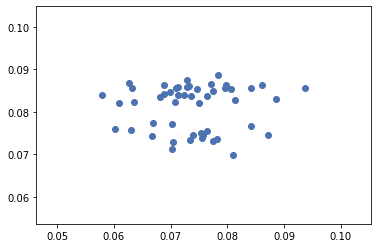

In [219]:
plt.scatter(a, b)
plt.xlabel

In [232]:
cla.portfolio_performance(verbose=True);

Expected annual return: 16.3%
Annual volatility: 9.8%
Sharpe Ratio: 1.46


In [236]:
cla_mu = mean_historical_return(random_portfolios[38])
cla_cov = CovarianceShrinkage(random_portfolios[38]).ledoit_wolf()
cla = CLA(cla_mu, cla_cov)
# cla.add_sector_constraints(sector_mapper, sector_lower_bull, sector_upper_bull)
# cla.efficient_risk(target_volatility=0.15)
cla.min_volatility()
# cla.max_sharpe()
weights = efficient_frontier.clean_weights()
cla.portfolio_performance(verbose=True);

Expected annual return: 9.4%
Annual volatility: 8.6%
Sharpe Ratio: 0.86
